In [41]:
%cd -q ..
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [54]:
from data.ls3d import LS3D

In [84]:
data = LS3D('/home/dawood/Datasets/LS3D-W/Train/300VW-3D/CatA/', augment=True, num_inst=3)
data.normalize = lambda x: x

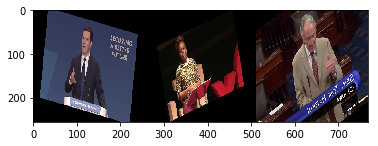

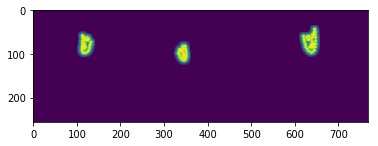

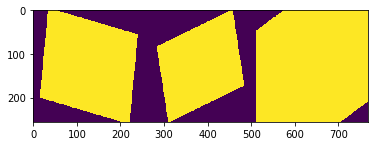

In [96]:
img, ann, mask = data[10]
img = img.permute(1,2,0).numpy()
mask = mask[0].numpy()
ann = ann.max(0)[0].numpy()
plt.imshow(img)
plt.figure()
plt.imshow(ann)
plt.figure()
plt.imshow(mask, vmin=0)

(array([ 854.,  839.,  494.,  497.,  437.,  479.,  217.,  508.,  612.,
        1886.]),
 array([0.01831564, 0.11648408, 0.21465251, 0.31282094, 0.41098937,
        0.50915784, 0.60732627, 0.7054947 , 0.80366313, 0.90183157,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

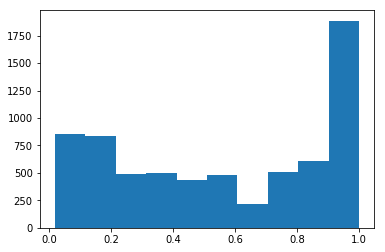

In [125]:
plt.hist(ann.reshape(-1)[ann.reshape(-1) > 0])

In [5]:
break

SyntaxError: 'break' outside loop (<ipython-input-5-6aaf1f276005>, line 4)

In [ ]:
import torchfile
import numpy as np
import imgaug as ia

from random import shuffle, randint
from pathlib import Path
from itertools import chain
from PIL import Image
from imgaug import augmenters as iaa

In [ ]:
data_root = Path('/media/SSD2/LS3D-W/300VW-3D/')

In [ ]:
data = []

imgs = chain(data_root.glob('**/*.jpg'), 
             data_root.glob('**/*.png'))
for img_path in imgs:
    img_path = img_path.as_posix()
    ann_path = img_path.replace('.jpg', '.t7').replace('.png', '.t7')
    if Path(ann_path).exists():
        data.append((img_path, ann_path))

shuffle(data)
data = [data[i:i+3] for i in range(len(data)//3)]

In [ ]:
shuffle(data)
for idx, _data in enumerate(data):
    _imgs = []
    _kpts = []
    for img, ann in _data:
        img = np.array(Image.open(img))
        h, w, _ = img.shape
        ann = torchfile.load(ann).astype(np.int32)
        kpt = ia.KeypointsOnImage([ia.Keypoint(x, y) for (x, y) in ann], img.shape)
    
        center = tuple(1 - ann.mean(0) / np.array([w, h]))
        w = ann[:, 0].max() - ann[:, 0].min()
        h = ann[:, 1].max() - ann[:, 1].min()
        s = randint(1, 10)
        aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(scale=(0.5,1.5)),
            iaa.Affine(rotate=(-60, 60)),
            iaa.Resize((256, 256)),
        ]).to_deterministic()
        img = aug.augment_image(img)
        kpt = aug.augment_keypoints([kpt])[0]
        kpt = kpt.keypoints

        h, w = img.shape[:2]
        hm = np.zeros((68, h, w), dtype=np.float)
        base = np.indices((h, w), dtype=np.float)
        kpt_base = np.tile(base, (68, 1, 1))
        kpt_arrays = []
        for i in range(68):
            kpt_arr = np.zeros_like(base)
            kpt_arr[0, :] = kpt[i].y #// 2
            kpt_arr[1, :] = kpt[i].x #// 2
            kpt_arrays.append(kpt_arr)
        
        kpt_arrays = np.concatenate(kpt_arrays, axis=0)
        kpt_arrays = (kpt_arrays - kpt_base) ** 2

        for i in range(68):
            dst = np.exp(-np.sum(kpt_arrays[2*i:2*(i + 1)], axis=0) / (2 * (4 ** 2)))
            hm[i] = np.maximum(hm[i], dst)

        _imgs.append(img)
        _kpts.append(hm)
        
    _imgs = np.hstack(_imgs)
    _kpts = np.concatenate(_kpts, 2)
    
    plt.figure()
    plt.imshow(_imgs)
    plt.imshow(_kpts.max(0), alpha=0.5)
    
    if idx == 1: break 

In [ ]:
kpt